In [62]:
import xarray as xr
import numpy as np

ncol = 36
nrow = 18

## BEHOLD, we have a data structure and its metadata in 5 simple pieces, ship it
aa = (np.arange(ncol * nrow).reshape([nrow, ncol]) * np.random.random((nrow,ncol)))
#aa = np.random.random((ncol, nrow))
#aa = np.arange(ncol * nrow) * np.random.random((ncol,nrow))
xmin = -180
xmax = 180
ymin = -90
ymax = 90
import math

In [53]:
np.random.random((ncol,nrow)).shape

(36, 18)

All well and good, we can even plot this with imshow(), we have built a hi-powered GiS and we can retire in full glory. 

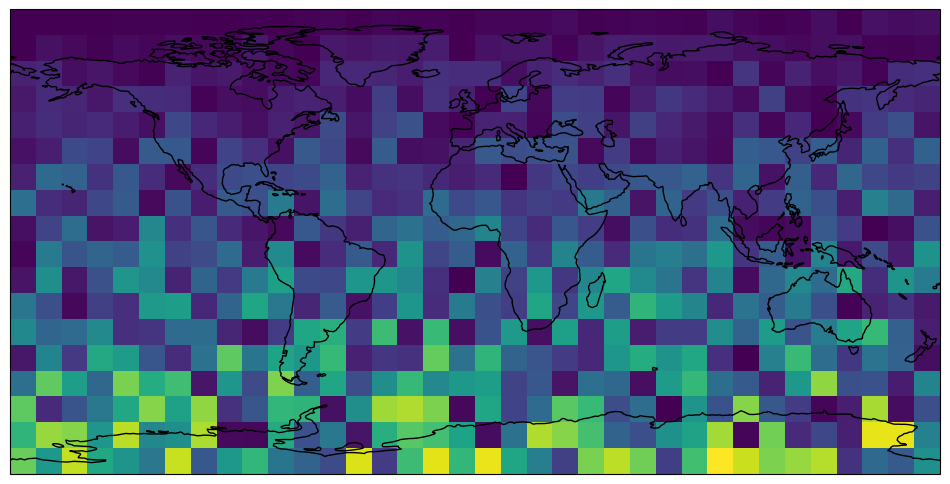

In [63]:
from matplotlib import pyplot
import cartopy.crs as ccrs

proj = ccrs.PlateCarree()  
fig = pyplot.figure(figsize=(12, 12))

ax = pyplot.axes(projection=proj)
ax.imshow(aa, extent = [xmin,xmax,ymin,ymax])

ax.set_xmargin(0.05)
ax.set_ymargin(0.10)
ax.coastlines(color='black')


There's another way to think about the georeferencing we used above, we can convert the four numbers extent to an offset and scale.

In [35]:
offset = [xmin, ymin]
scale = [(xmax - xmin)/aa.shape[1], (ymax - ymin)/aa.shape[0]]
[offset, scale]

[[-180, -90], [10.0, 10.0]]

Above we have stored the bottom left corner of the bottom left cell, and the width and height of each cell.   This is neat because now we can change the size of our array by stride sampling and we only need to update the scale values, or we can take a subset window of the array and only change the offset values. This is very nice in graphics contexts for zooming in and out or displaying different regions, but it's not very nice for a human because we no longer have a compact numeric representation of where our data lives, we need to consult the shape of the data and do calculations (offset, and offset + shape * scale gives us back our extent). 

There's no good or bad here, just a very rich history of choices made for what is most effective in a given context. There are other wrinkles too, when we store the offset take the left edge for offset x and positive scale x, but the top edge for y and negative scale y. (Probably because that's how cathode rays worked, or even maybe because that's how some of us read). 

Another wrinkle is that a modern day affine transform** is expressed in left-edge, top-edge form in software, but in some file formats it is stored as centre-of-left-cell and centre-of-top-cell form (the worldfile). The fact is, however you do it doesn't add any more information to the situation than we had in our original specification: ncol, nrow, xmin, xmax, ymin, ymax - just we need rules and conventions about what a particular representation actually means. 

**(that's a fancy way of saying offset and scale but also has  more generality brought to us by matrix math and graphics magic, math that is truly general and n-dimensional for transforming "things" )


## Rectilinear georeferencing

We glossed over the centre-point vs edge-point referencing by offset and scale above. There's a way to represent the position of the cells more explicitly and we can do that in several different ways. 

Let's create lon and lat arrays of the cell centre points. 

In [82]:
## we could generate xs and ys as the centres

clon = [x * (xmax - xmin)/ncol + xmin + (xmax - xmin)/ncol/ 2 for x in range(ncol)] 
clat = [y * (ymax - ymin)/nrow + ymin + (ymax - ymin)/nrow/ 2 for y in range(nrow)] 

In [89]:
elon = [x * (xmax - xmin)/ncol + xmin for x in range(ncol + 1)]
elat = [y * (ymax - ymin)/nrow + ymin for y in range(nrow + 1)]

print([np.NaN, clat])
print(elat)


[nan, [-85.0, -75.0, -65.0, -55.0, -45.0, -35.0, -25.0, -15.0, -5.0, 5.0, 15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0]]
[-90.0, -80.0, -70.0, -60.0, -50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]


In [ ]:
# and produce a DataArray
ds = xr.DataArray(
    data=aa,
    dims=["x", "y"],
        name = "world10",
    coords=dict(
        lon=(["x"], lon),
        lat=(["y"], lat)
    )
).to_dataset()

In [81]:
## or, we could specify a dataset from a memory address for GDAL
def address(x):
   return x.__array_interface__["data"][0]

def mem_dsn(x, extent): 
  nrow,ncol = x.shape
  xmin = extent[0]
  xmax = extent[1]
  ymin = extent[2]
  ymax = extent[3]
  return f"MEM:::DATAPOINTER=\"{address(x)}\",PIXELS={ncol},LINES={nrow},BANDS=1,DATATYPE=Float64,GEOTRANSFORM={xmin}/{(xmax-xmin)/ncol}/0/{ymax}/0/{(ymin-ymax)/nrow},PIXELOFFSET=0,LINEOFFSET=0,BANDOFFSET={ncol * nrow * 8}"

## run but don't save because of maybe garbage collection
print(mem_dsn(aa, [xmin, xmax, ymin, ymax]))

from osgeo import gdal
gdal.UseExceptions()

ds = gdal.Open(mem_dsn(aa, [xmin, xmax, ymin, ymax]))

import xarray
xarray.open_dataset(mem_dsn(aa, [xmin, xmax, ymin, ymax]), engine = "rasterio")



MEM:::DATAPOINTER="94888470543152",PIXELS=36,LINES=18,BANDS=1,DATATYPE=Float64,GEOTRANSFORM=-180/10.0/0/90/0/-10.0,PIXELOFFSET=0,LINEOFFSET=0,BANDOFFSET=5184


<xarray.Dataset>
Dimensions:      (band: 1, x: 36, y: 18)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -175.0 -165.0 -155.0 -145.0 ... 155.0 165.0 175.0
  * y            (y) float64 85.0 75.0 65.0 55.0 ... -55.0 -65.0 -75.0 -85.0
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float64 ...

In [47]:
ds.world10.to_numpy()

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17],
       [ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
         31,  32,  33,  34,  35],
       [ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53],
       [ 54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71],
       [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89],
       [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107],
       [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125],
       [126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143],
       [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161],
       [162, 163, 164, 165, 166, 167,